In [1]:
import ztfimg
from ztfimg import catalog as catalog
import ztfin2p3
from ztfin2p3 import catalog
import pandas as pd
import numpy as np
import jax
import optax
import jax.numpy as jnp
from jax.scipy import stats as jstats
import matplotlib.pyplot as plt
from scipy import optimize, stats
from scipy.stats import multivariate_normal

# Image selection

#data download
from ztfquery import io
filename = ['ztf_20200924431759_000655_zr_c13_o_q3_sciimg.fits', 'ztf_20200924431759_000655_zr_c13_o_q3_mskimg.fits']
io.get_file(filename, downloadit=True)

In [2]:
liste_file = ["/sps/ztf/data/sci/2020/0924/431759/ztf_20200924431759_000655_zr_c13_o_q3_sciimg.fits", "/sps/ztf/data/sci/2020/0924/431759/ztf_20200924431759_000655_zr_c01_o_q1_sciimg.fits",
             "/sps/ztf/data/sci/2020/0924//278681/ztf_20200924278681_000682_zg_c01_o_q1_sciimg.fits", "/sps/ztf/data/sci/2020/0924/352269/ztf_20200924352269_000650_zr_c06_o_q2_sciimg.fits",
             "/sps/ztf/data/sci/2020/0924/509537/ztf_20200924509537_000700_zg_c03_o_q2_sciimg.fits", "/sps/ztf/data/sci/2020/0924/431759/ztf_20200924431759_000655_zr_c09_o_q1_sciimg.fits"]

img1 = ztfimg.ScienceQuadrant.from_filename(liste_file[0])

q1 = img1.get_ccd().get_quadrant(1) #selects quadrant 1 
qimg1 = q1.get_data() #converted to numpy array

# importing data into a pandas.dataframe
qimg1_catalog = ztfin2p3.catalog.get_img_refcatalog(q1, which="gaia_dr2") # selects the data corresponding to the quadrant in the gaia_dr2 catalog
qimg1_catalog['isolated'] = ztfimg.catalog.get_isolated(qimg1_catalog, seplimit=20) #select stars that are 15 arcsec apart and add a Boolean column
qimg_catalog_isolated = qimg1_catalog.loc[qimg1_catalog['isolated'] == True] # we keep only isolated stars (whose Boolean is True)
qimg_catalog_isolated = qimg_catalog_isolated.drop('isolated', axis=1) #supression of isolated column

# magnitude selection
mag_inf = qimg_catalog_isolated.phot_g_mean_mag > 14 #selects magnitudes above 14
mag_sup = qimg_catalog_isolated.phot_g_mean_mag < 18 #selects magnitudes below 18
qimg_catalog_isolated_mag = qimg_catalog_isolated.loc[mag_inf & mag_sup] #application of the mask on magnitudes

# location selection
mag_bord_left = qimg_catalog_isolated_mag.x > 15 # removes stars on the left edge of 15 pixels
mag_bord_right = qimg_catalog_isolated_mag.x < (q1.shape[0]-15) # removes stars on the right edge of 15 pixels
mag_bord_top = qimg_catalog_isolated_mag.y > 15 # removes the stars on the top edge by 15 pixels
mag_bord_bottom = qimg_catalog_isolated_mag.y < (q1.shape[1]-15) # removes stars on the bottom edge of 15 pixels
mag_bord_combined = np.logical_and.reduce((mag_bord_left, mag_bord_right, mag_bord_top, mag_bord_bottom)) #edge selection
qimg_catalog_isolated_mag_bord = qimg_catalog_isolated_mag[mag_bord_combined] #application of edge mask
qimg_catalog_isolated_mag_bord

,id,coord_ra,coord_dec,phot_g_mean_flux,phot_bp_mean_flux,phot_rp_mean_flux,phot_g_mean_fluxErr,phot_bp_mean_fluxErr,phot_rp_mean_fluxErr,coord_raErr,...,ra,dec,phot_g_mean_mag,phot_bp_mean_mag,phot_rp_mean_mag,phot_g_mean_magErr,phot_bp_mean_magErr,phot_rp_mean_magErr,x,y
3292,220210914664501376,1.026161,0.637330,3.411760e+05,2.496884e+05,4.863944e+05,333.605022,4307.633356,1871.193552,0.002145,...,58.794687,36.516333,17.567620,17.906570,17.182594,0.001062,0.018731,0.004177,665.035175,1267.744563
3314,220210949024241920,1.025702,0.637414,2.846405e+05,1.552300e+05,4.988820e+05,263.706599,2006.851979,3996.709121,0.001880,...,58.768417,36.521120,17.764324,18.422627,17.155071,0.001006,0.014037,0.008698,589.417449,1282.097111
3343,220214655577103232,1.022990,0.637796,6.637216e+05,4.199027e+05,1.086072e+06,553.114736,1744.992099,2613.982357,0.001542,...,58.612995,36.543040,16.845101,17.342194,16.310420,0.000905,0.004512,0.002613,142.980478,1344.672348
3494,220216407923781760,1.023645,0.639737,3.310731e+05,2.083656e+05,5.224247e+05,297.967950,1487.596690,3983.500840,0.001617,...,58.650511,36.654212,17.600256,18.103001,17.105006,0.000977,0.007751,0.008279,236.507139,1743.317737
3524,220213216767321088,1.026577,0.638661,7.455134e+05,4.821637e+05,1.142259e+06,524.353589,3058.071864,5102.794374,0.001253,...,58.818547,36.592557,16.718927,17.192079,16.255654,0.000764,0.006886,0.004850,723.407453,1541.004010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45776,220167793192842368,1.033080,0.634488,4.161678e+06,3.407272e+06,5.055197e+06,1242.641362,5762.443728,7624.821103,0.000454,...,59.191138,36.353509,14.851894,15.069049,14.640720,0.000324,0.001836,0.001638,1820.108284,731.855584
45799,220175077457571712,1.036926,0.636100,1.675470e+06,1.183528e+06,2.416099e+06,681.649828,2936.846731,3462.371170,0.000738,...,59.411462,36.445829,15.839724,16.217119,15.442279,0.000442,0.002694,0.001556,2436.769333,1085.493345
45891,220225586272711168,1.030969,0.639192,6.834436e+05,4.806962e+05,9.924018e+05,407.310306,1946.126256,4175.423717,0.001170,...,59.070190,36.622983,16.813309,17.195389,16.408347,0.000647,0.004396,0.004568,1437.085775,1675.756830
45903,220222596975471872,1.031456,0.639021,6.083751e+05,5.244016e+05,7.197826e+05,425.536839,2348.414058,4584.703300,0.001287,...,59.098059,36.613195,16.939637,17.100906,16.757062,0.000759,0.004862,0.006916,1517.911040,1644.046424


# Functions

The probability density function for multivariate_normal is:
$$
f(x) = \frac{1}{\sqrt{2\pi \det(\Sigma)}} \exp\left(-\frac{1}{2} (x - \mu)^T \Sigma^{-1} (x - \mu)\right)
$$

In [3]:
def get_model_gauss(x0, y0, A, sig_x, sig_y, b):
    """
    returns the normalized Gaussian function
    
    Parameters:
    -----------
    x0, y0: float
        image center coordinates (where the star is located)
    A: float
        amplitude
    sig_x, sig_y: float
        standard deviation in x and y
    b: float
        background
    
    Returns:
    -------
    model : arraylike
        the normalized Gaussian function
    """
    
    mu = [x0, y0]
    cov = ([sig_x**2 , 0] , [0, sig_y**2])
    model = A * multivariate_normal.pdf(pos.T, mean = mu, cov = cov) + b    
    return model

def get_logprior(params):
    """
    Returns the probability to have sigmax and sigma y
    
    Parameters:
    -----------
    params: list
        selected model parameters
    
    Returns:
    -------
    logprior: float
        sum of the two sigma probabilities
    """
    
    x0, y0, A, sig_x, sig_y, *_ = params
    logprior_sx = stats.norm.logpdf(sig_x, loc=1, scale=0.5)
    logprior_sy = stats.norm.logpdf(sig_y, loc=1, scale=0.5)
    logprior = logprior_sx + logprior_sy # get the maximize
    return logprior

def get_likelihood(params, stamp):
    """
    Computes the Chi squared from selected model 
    
    Parameters:
    ----------
    params: list
        selected model parameters
    stamp: arraylike
        image of one star
    
    Returns:
    --------
    summ: float
        chi squared
    """
    
    model = get_model_gauss(*params)
    summ = np.sum((model - stamp)**2)
    return summ


def get_logprob(params, stamp):
    """ 
    Computes the sum of the sigma probabilities and the chi squared
    
    Parameters:
    -----------
    params: list
        selected model parameters
    stamp: arraylike
        image of one star
    
    Returns:
    logprob: float
        sum of the sigma probabilities and the chi squared
    """
    
    logprior = -1* get_logprior(params) # to minimize
    likelihood = get_likelihood(params, stamp)
    logprob = logprior + likelihood
    return logprob

def fits(params, data):
    """
    Minimizes the parameters of a chosen model
    
    Parameters:
    -----------
    params: list
        selected model parameters
    data: arraylike
        data on which parameters are fitted
    
    Returns:
    --------
    out: list
        fitted parameters
    """
    
    out = optimize.minimize(get_logprob, params, data, method="BFGS")
    return out

# Fit for 1 star

chi squared: 0.00018126649863760863
optimzed parameters x0=0.38628, y0=0.54793, A= 0.13723, sig_x=0.99990, sig_y=0.99990, b=0.00304
optimized parameters errors x0_err=0.41346, y0_err=0.58064, A_err= 0.08133, sig_x_err=0.01463, sig_y_err=0.01427, b_err=0.00127


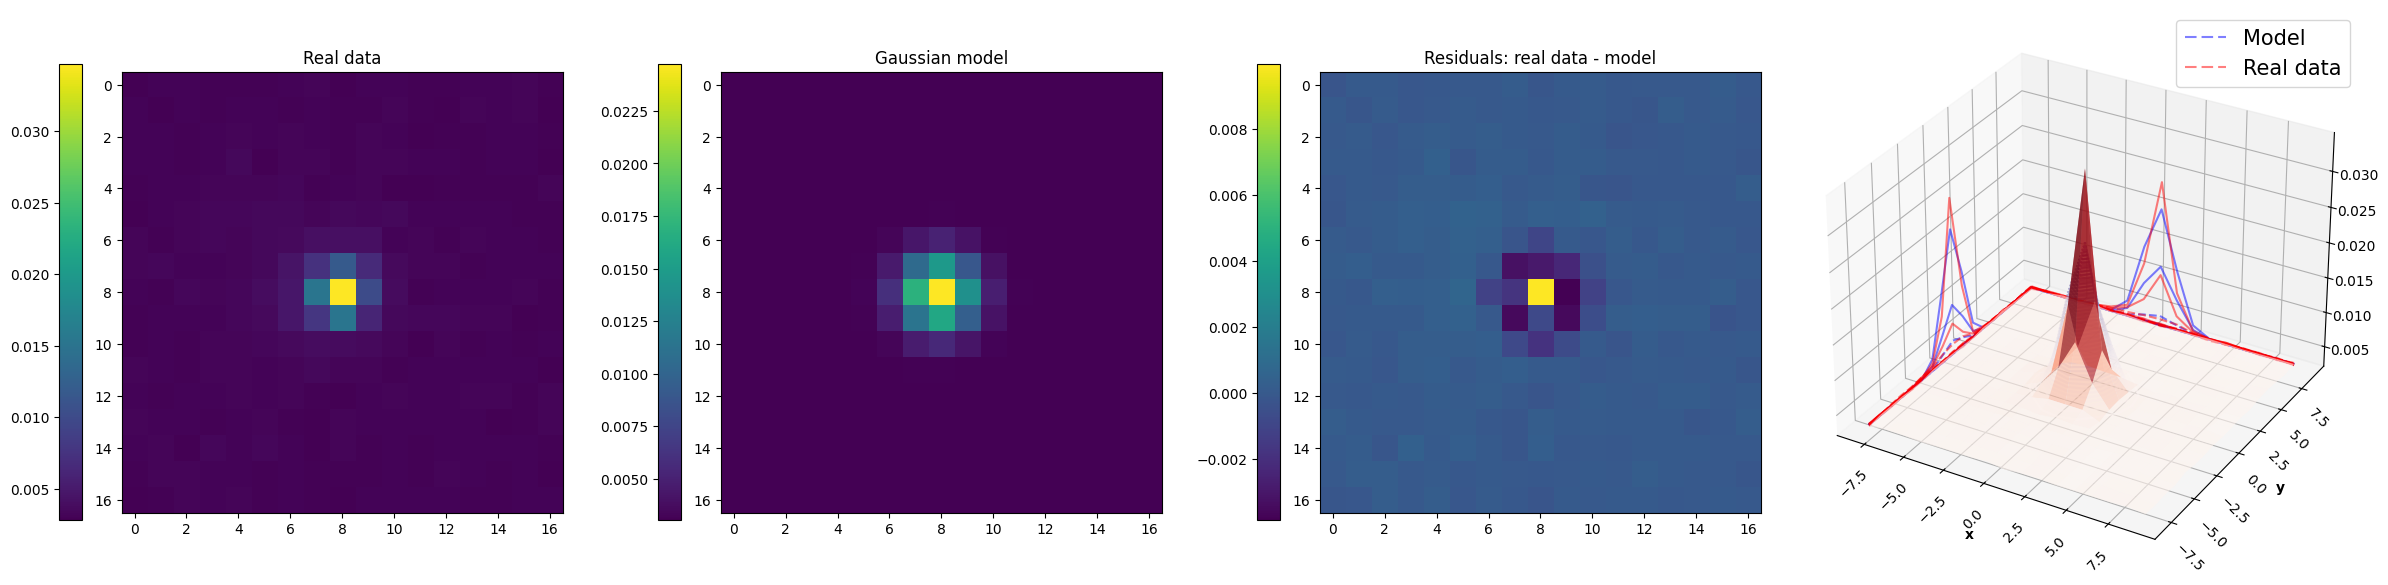

CPU times: user 1.13 s, sys: 48.1 ms, total: 1.18 s
Wall time: 1.19 s


In [4]:
%%time

from mpl_toolkits.mplot3d import Axes3D

# create an image centered on a star
df = qimg_catalog_isolated_mag_bord.loc[45903]
x = df.x
y = df.y
x0 = int(round(x))
y0 = int(round(y))
size = 17
left = x0 - (size // 2)
top = y0 - (size // 2)
right = left + size
bottom = top + size
stamp = qimg1[top:bottom, left:right]

X = np.linspace(left, right, size) - x0
Y = np.linspace(top, bottom, size) - y0
X, Y = np.meshgrid(X, Y)
pos = np.vstack((X.ravel(), Y.ravel()))

# fitting a gaussian model to the data
params = (0, 0, 1, .5, 1., 0) # initial parameters for the gaussian model: x0, y0, A, sig_x, sig_y, b
to_fit = stamp/stamp.sum()
fout = fits(params, to_fit.ravel())
model = get_model_gauss(*fout.x).reshape(size,size)
residuals = (to_fit - model).reshape(size, size)

hessian_inv = fout.hess_inv / fout.hess_inv.sum()
errors = np.sqrt(np.diag(hessian_inv))
print("chi squared:", get_likelihood(fout.x, to_fit.ravel()))
print("optimzed parameters", f"x0={fout.x[0]:.5f}, y0={fout.x[1]:.5f}, A= {fout.x[2]:.5f}, sig_x={fout.x[3]:.5f}, sig_y={fout.x[4]:.5f}, b={fout.x[5]:.5f}")
print("optimized parameters errors", f"x0_err={errors[0]:.5f}, y0_err={errors[1]:.5f}, A_err= {errors[2]:.5f}, sig_x_err={errors[3]:.5f}, sig_y_err={errors[4]:.5f}, b_err={errors[5]:.5f}")

# Data and results display
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize = (24, 6))
im1 = ax1.imshow(to_fit)
ax1.set_title('Real data')
plt.colorbar(im1, ax=ax1, location = 'left', orientation = 'vertical', shrink=0.8, pad=0.07)
im2 = ax2.imshow(model.reshape(17,17))
ax2.set_title('Gaussian model')
plt.colorbar(im2, ax=ax2, location = 'left', orientation = 'vertical', shrink=0.8, pad=0.07)
im3 = ax3.imshow(residuals)
ax3.set_title('Residuals: real data - model')
plt.colorbar(im3, ax=ax3, location = 'left', orientation = 'vertical', shrink=0.8, pad=0.07)

fig = plt.gcf()
spec = ax4.get_subplotspec()
fig.delaxes(ax4)
ax4_3d = fig.add_subplot(spec, projection='3d')
ax4_3d.plot_surface(X, Y, to_fit, cmap='Reds', alpha=0.6, label='real data')
ax4_3d.contour3D(X, Y, model.reshape(17,17), levels=50, cmap='Purples', alpha=0.6)
ax4_3d.set_xlabel('x', fontdict=dict(weight='bold'))
ax4_3d.set_ylabel('y', fontdict=dict(weight='bold'))
ax4_3d.xaxis.set_tick_params(rotation=45)
ax4_3d.yaxis.set_tick_params(rotation=-45)
c1 = ax4_3d.contour(X, Y, model.reshape(size, size), 8, zdir='y', offset=np.max(Y), colors='blue', alpha=0.5)
c2 = ax4_3d.contour(X, Y, to_fit.reshape(size, size), 8, zdir='y', offset=np.max(Y), colors='red', alpha=0.5)
ax4_3d.contour(X, Y, model.reshape(size, size), 8, zdir='x', offset=np.min(X), colors='blue', alpha=0.5)
ax4_3d.contour(X, Y, to_fit.reshape(size, size), 8, zdir='x', offset=np.min(X), colors='red', alpha=0.5)
h1, _ = c1.legend_elements()
h2, _ = c2.legend_elements()
ax4_3d.legend([h1[0], h2[0]], ['Model', 'Real data'], fontsize=15)

plt.tight_layout()
plt.show()

# Fit with for loop

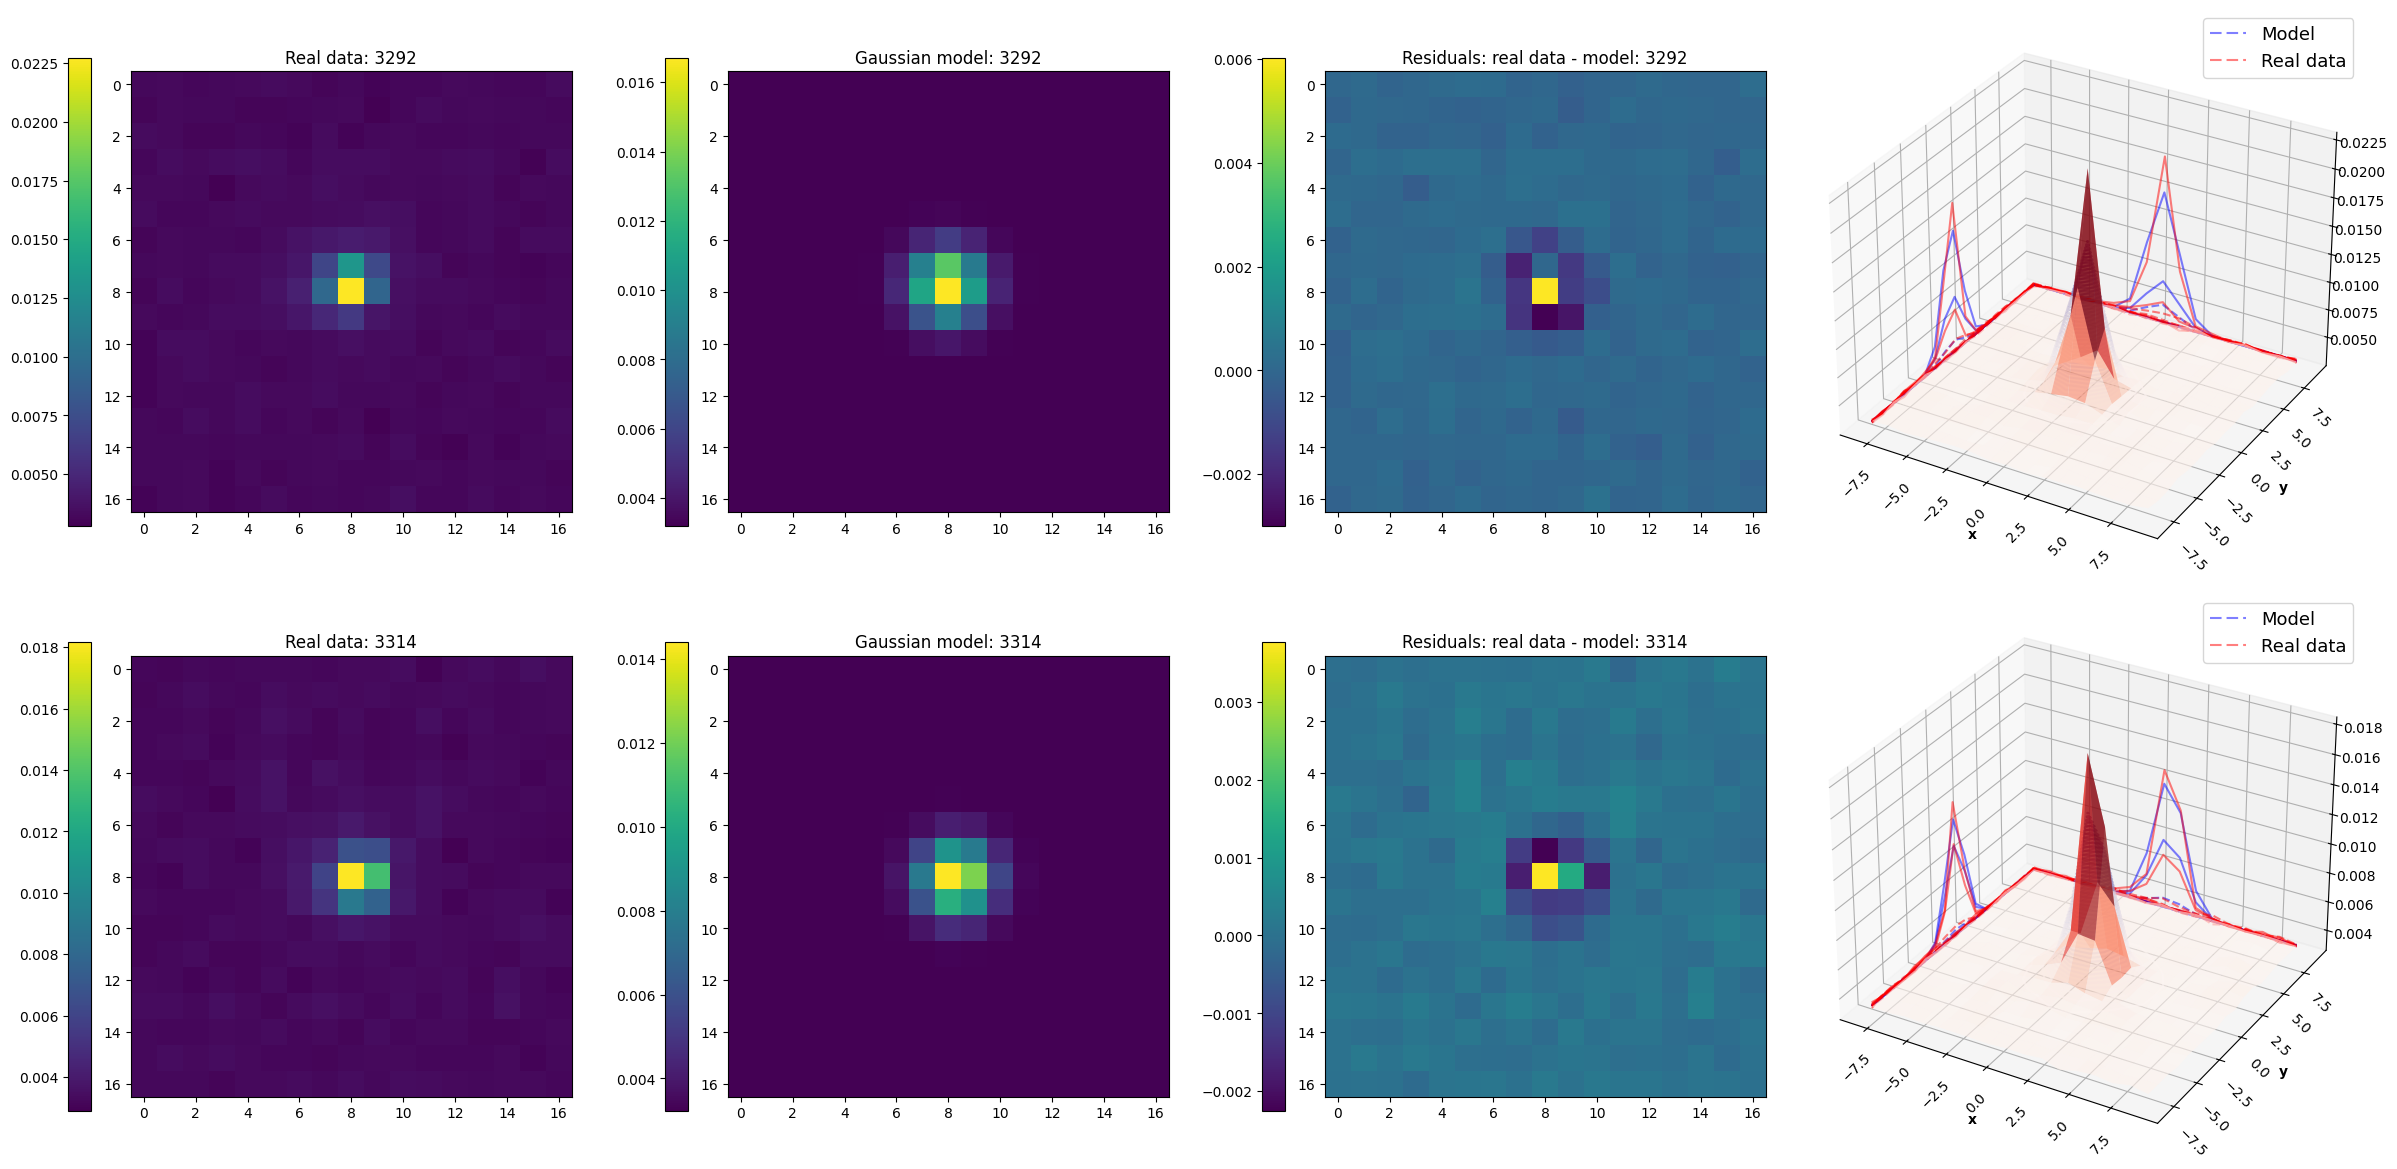

CPU times: user 2.56 s, sys: 124 ms, total: 2.69 s
Wall time: 2.69 s


In [5]:
%%time

total_images = 2 # number of data items selected in the dataframe
end = qimg_catalog_isolated_mag_bord.head(total_images)
num_cols = 4
num_rows = total_images 
fig_height = num_rows * 6
fig_width = num_cols * 6
fig, axes = plt.subplots(total_images, num_cols, figsize = (fig_width, fig_height))
size = 17

params = (0, 0, 1, .5, 1., 0) # initial parameters for the model

noises = []

for i, (index, row) in enumerate(end.iterrows()):
    
    # create an image centered on a star
    x0 = int(round(row['x']))
    y0 = int(round(row['y']))
    left = x0- (size // 2)
    top = y0 - (size // 2)
    right = left + size
    bottom = top + size
    X = np.linspace(left, right, size) - x0
    Y = np.linspace(top, bottom, size) - y0
    X, Y = np.meshgrid(X, Y)
    pos = np.vstack((X.ravel(), Y.ravel()))
    stamp = qimg1[top:bottom, left:right]
    
    # fitting a gaussian model to the data
    to_fit = stamp / stamp.sum()
    fout = fits(params, to_fit.ravel())
    #print(f"param opt pour {index}: x0, y0, A, sig_x, sig_y, b", fout.x)
    #print("chi squared:", get_likelihood(fout.x, to_fit.ravel()))
    model = get_model_gauss(*fout.x).reshape(size,size)
    residuals = to_fit - model

    hessian_inv = fout.hess_inv
    errors = np.sqrt(np.diag(hessian_inv))
    #print("errors on optimized parameters", errors)

#     noise = fout.x[2] / errors[2]
#     noises.append(noise)

# plt.scatter(end['phot_g_mean_mag'], noises)
# plt.xlabel('magnitude')
# plt.ylabel('A/ err(A)')
    
    # Data and results display
    ax1 = axes[i, 0]
    im1 = ax1.imshow(to_fit)
    ax1.set_title(f'Real data: {index}')
    plt.colorbar(im1, ax=ax1, location = 'left', orientation = 'vertical', shrink=0.8, pad=0.07)
    ax2 = axes[i, 1]
    im2 = ax2.imshow(model)
    ax2.set_title(f'Gaussian model: {index}')
    # ax2.text(0.98, 0.16, f"chi squared={get_likelihood(fout.x, to_fit.ravel()):.6f}",
    #         color = 'white', fontsize=13, horizontalalignment='right', verticalalignment='bottom', transform=ax2.transAxes)
    # ax2.text(0.98, 0.10, f"x0={fout.x[0]:.5f}, y0={fout.x[1]:.5f}, A= {fout.x[2]:.5f}", 
    #          color = 'white', fontsize=13, horizontalalignment='right', verticalalignment='bottom', transform=ax2.transAxes)
    # ax2.text(0.98, 0.04, f"sig_x={fout.x[3]:.5f}, sig_y={fout.x[4]:.5f}, b={fout.x[5]:.5f}",
    #          color = 'white', fontsize=13, horizontalalignment='right', verticalalignment='bottom', transform=ax2.transAxes)
    plt.colorbar(im2, ax=ax2, location = 'left', orientation = 'vertical', shrink=0.8, pad=0.07)
    ax3 = axes[i, 2]
    im3 = ax3.imshow(residuals)
    ax3.set_title(f'Residuals: real data - model: {index}')
    # ax3.text(0.98, 0.10, f"x0_ERR={errors[0]:.4f}, y0_ERR={errors[1]:.4f}, A_ERR= {errors[2]:.4f}", 
    #          color = 'white', fontsize=11, horizontalalignment='right', verticalalignment='bottom', transform=ax3.transAxes)
    # ax3.text(0.98, 0.04, f"sig_x_ERR={errors[3]:.4f}, sig_y_ERR={errors[4]:.4f}, b_ERR={errors[5]:.4f}",
    #          color = 'white', fontsize=11, horizontalalignment='right', verticalalignment='bottom', transform=ax3.transAxes)
    plt.colorbar(im3, ax=ax3, location = 'left', orientation = 'vertical', shrink=0.8, pad=0.07)
    
    ax4 = axes[i, 3]
    fig = plt.gcf()
    spec = ax4.get_subplotspec()
    fig.delaxes(ax4)
    ax4_3d = fig.add_subplot(spec, projection='3d')
    ax4_3d.plot_surface(X, Y, to_fit, cmap='Reds', alpha=0.6, label='real data')
    ax4_3d.contour3D(X, Y, model.reshape(17,17), levels=50, cmap='Purples', alpha=0.6)
    ax4_3d.set_xlabel('x', fontdict=dict(weight='bold'))
    ax4_3d.set_ylabel('y', fontdict=dict(weight='bold'))
    ax4_3d.xaxis.set_tick_params(rotation=45)
    ax4_3d.yaxis.set_tick_params(rotation=-45)
    c1 = ax4_3d.contour(X, Y, model.reshape(size, size), 8, zdir='y', offset=np.max(Y), colors='blue', alpha=0.5)
    c2 = ax4_3d.contour(X, Y, to_fit.reshape(size, size), 8, zdir='y', offset=np.max(Y), colors='red', alpha=0.5)
    ax4_3d.contour(X, Y, model.reshape(size, size), 8, zdir='x', offset=np.min(X), colors='blue', alpha=0.5)
    ax4_3d.contour(X, Y, to_fit.reshape(size, size), 8, zdir='x', offset=np.min(X), colors='red', alpha=0.5)
    h1, _ = c1.legend_elements()
    h2, _ = c2.legend_elements()
    ax4_3d.legend([h1[0], h2[0]], ['Model', 'Real data'], fontsize=13)
    
plt.tight_layout()
plt.show()

## Fit with custom_function

In [6]:
def plot_images(to_fit, model, residuals):
    """ 
    display function 
    
    Parameters:
    -----------
    to_fit: function
        model optimization
    model: arraylike
        optimized model
    residuals: arraylike
        residuals from real data minus optimized model
    """
    
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize = (18,5))
    im1 = ax1.imshow(to_fit)
    ax1.set_title('Real data')
    plt.colorbar(im1, ax=ax1, location = 'left', orientation = 'vertical', shrink=0.7, pad=0.07)
    im2 = ax2.imshow(model.reshape(17,17))
    ax2.set_title('Gaussian model')
    # ax2.text(0.98, 0.16, f"chi squared={get_likelihood(fout.x, to_fit.ravel()):.6f}",
    #         color = 'white', fontsize=10, horizontalalignment='right', verticalalignment='bottom', transform=ax2.transAxes)
    # ax2.text(0.98, 0.10, f"x0={fout.x[0]:.5f}, y0={fout.x[1]:.5f}, A= {fout.x[2]:.5f}", 
    #          color = 'white', fontsize=10, horizontalalignment='right', verticalalignment='bottom', transform=ax2.transAxes)
    # ax2.text(0.98, 0.04, f"sig_x={fout.x[3]:.5f}, sig_y={fout.x[4]:.5f}, b={fout.x[5]:.5f}",
    #          color = 'white', fontsize=10, horizontalalignment='right', verticalalignment='bottom', transform=ax2.transAxes)
    plt.colorbar(im2, ax=ax2, location = 'left', orientation = 'vertical', shrink=0.7, pad=0.07)
    im3 = ax3.imshow(residuals.reshape(size, size))
    ax3.set_title('Residuals: real data - model')
    plt.colorbar(im3, ax=ax3, location = 'left', orientation = 'vertical', shrink=0.7, pad=0.07)

    fig = plt.gcf()
    spec = ax4.get_subplotspec()
    fig.delaxes(ax4)
    ax4_3d = fig.add_subplot(spec, projection='3d')
    ax4_3d.plot_surface(X, Y, to_fit, cmap='Reds', alpha=0.6, label='real data')
    ax4_3d.contour3D(X, Y, model.reshape(17,17), levels=50, cmap='Purples', alpha=0.6)
    ax4_3d.set_xlabel('x', fontdict=dict(weight='bold'))
    ax4_3d.set_ylabel('y', fontdict=dict(weight='bold'))
    ax4_3d.xaxis.set_tick_params(rotation=45)
    ax4_3d.yaxis.set_tick_params(rotation=-45)
    c1 = ax4_3d.contour(X, Y, model.reshape(size, size), 8, zdir='y', offset=np.max(Y), colors='blue', alpha=0.5)
    c2 = ax4_3d.contour(X, Y, to_fit.reshape(size, size), 8, zdir='y', offset=np.max(Y), colors='red', alpha=0.5)
    ax4_3d.contour(X, Y, model.reshape(size, size), 8, zdir='x', offset=np.min(X), colors='blue', alpha=0.5)
    ax4_3d.contour(X, Y, to_fit.reshape(size, size), 8, zdir='x', offset=np.min(X), colors='red', alpha=0.5)
    h1, _ = c1.legend_elements()
    h2, _ = c2.legend_elements()
    ax4_3d.legend([h1[0], h2[0]], ['Model', 'Real data'], fontsize=13)

    plt.tight_layout()
    plt.show()

In [7]:
def custom_function(row):
    """
    function for model fitting for each row of a dataframe
    
    Parameters:
    -----------
    row: pandas
        dataframe row
    
    Returns:
    -------
    fout.x: List
        optimized parameters
    model: arraylike
        optimized model
    residuals: arraylike
        residuals from real data minus optimized model
    """
    
    #create an image centered on a star
    x0 = int(round(row['x']))
    y0 = int(round(row['y']))
    left = x0 - (size // 2)
    top = y0 - (size // 2)
    right = left + size
    bottom = top + size  
    X = np.linspace(left, right, size) - x0
    Y = np.linspace(top, bottom, size) - y0
    X, Y = np.meshgrid(X, Y)
    pos = np.vstack((X.ravel(), Y.ravel()))
    stamp = qimg1[top:bottom, left:right]
    
    # fitting a gaussian model to the data
    to_fit = stamp / stamp.sum()
    fout = fits(params, to_fit.ravel())
    #print(f"Optimal parameters for index {row.name}: x0={fout.x[0]}, y0={fout.x[1]}, A={fout.x[2]}, sig_x={fout.x[3]}, sig_y={fout.x[4]}, b={fout.x[5]}")
    model = get_model_gauss(*fout.x).reshape(size, size)
    residuals = to_fit - model
       
     # Data and results display
    plot_images(to_fit, model, residuals)
    
    return fout.x, model, residuals

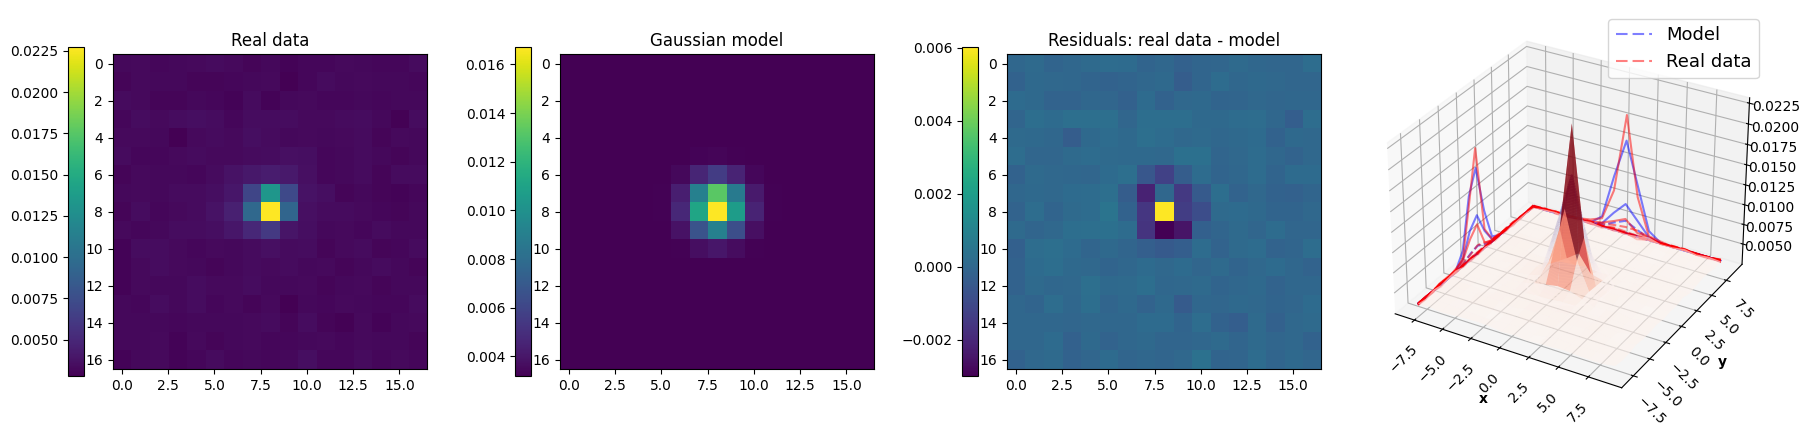

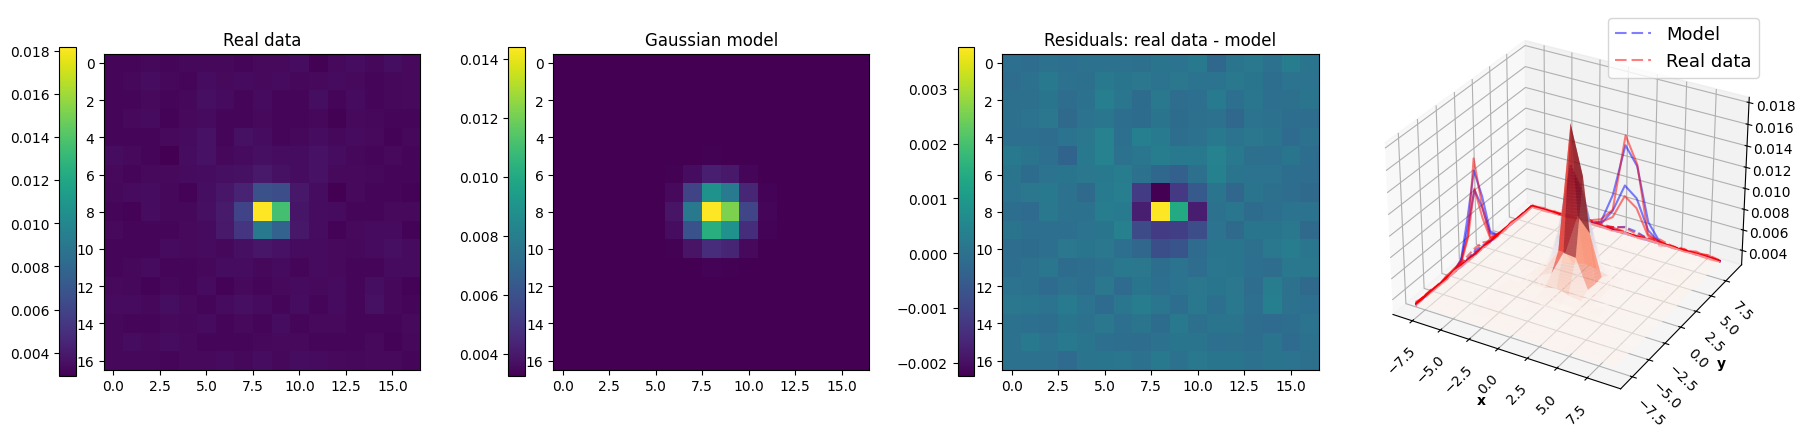

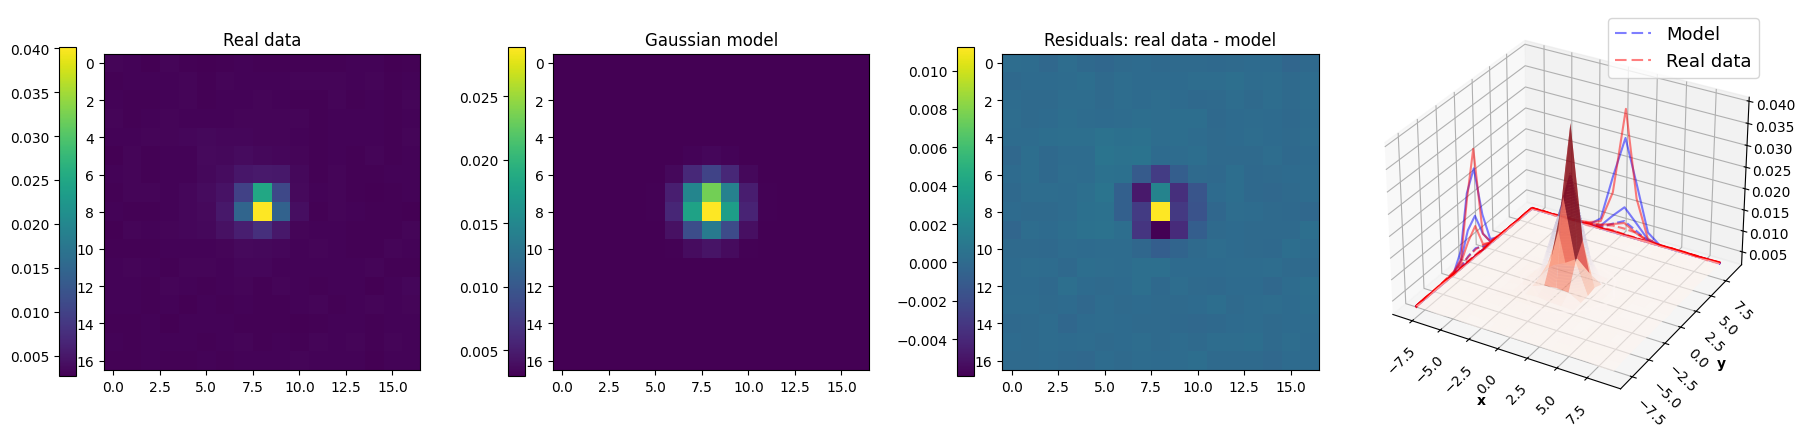

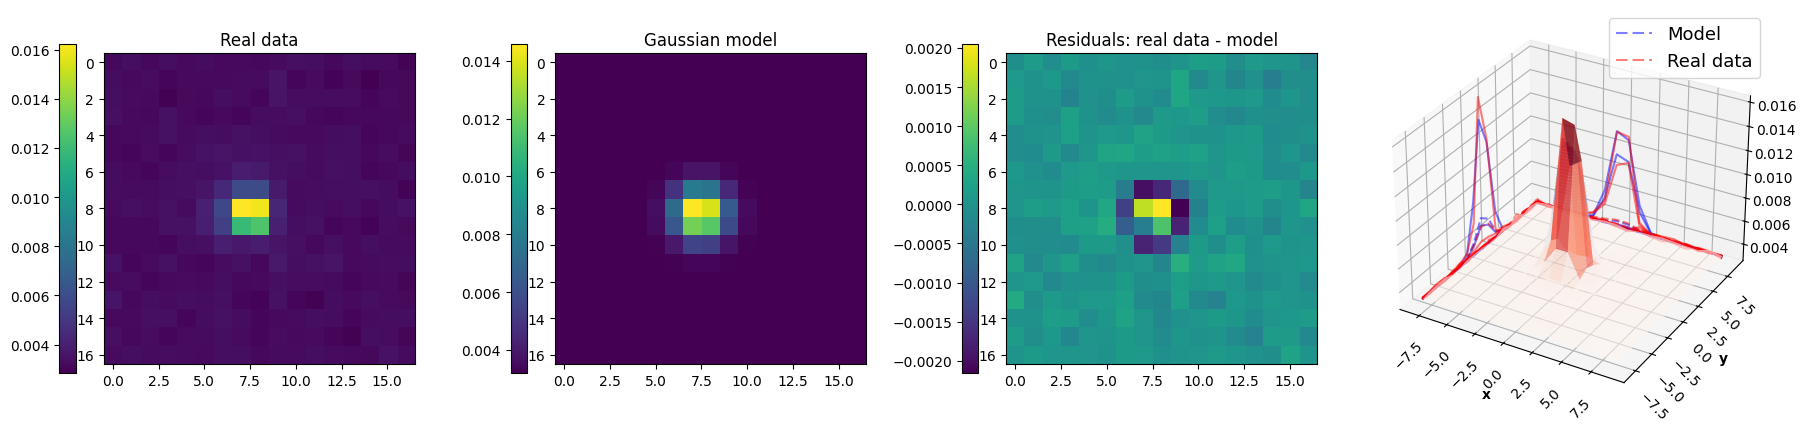

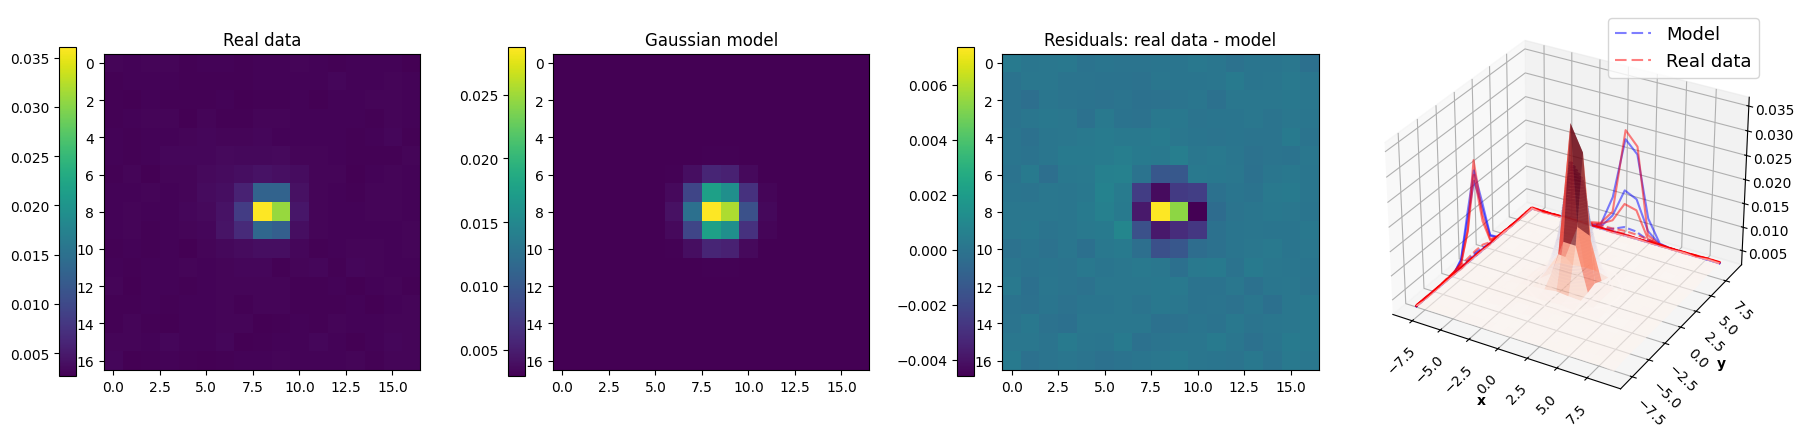

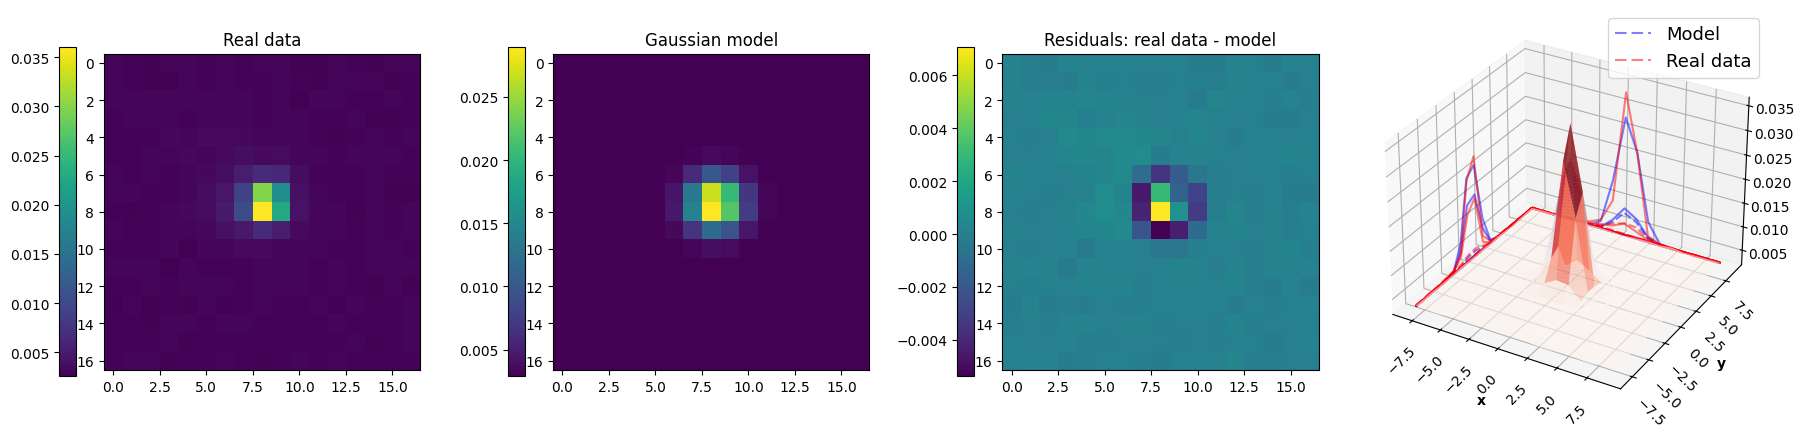

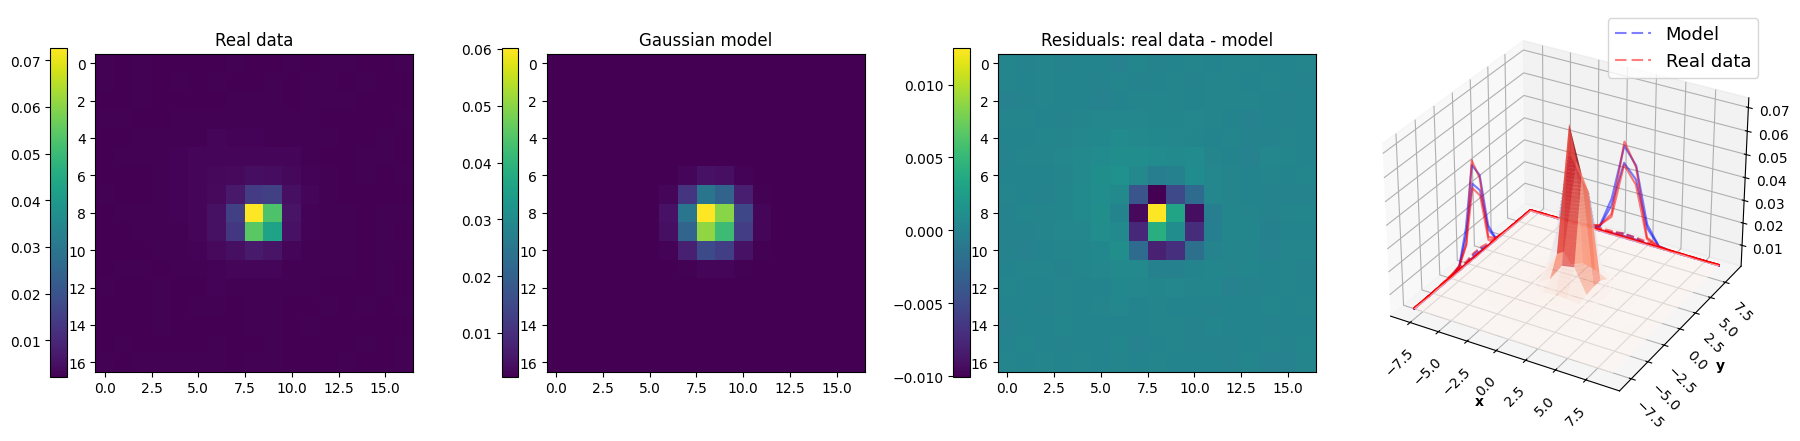

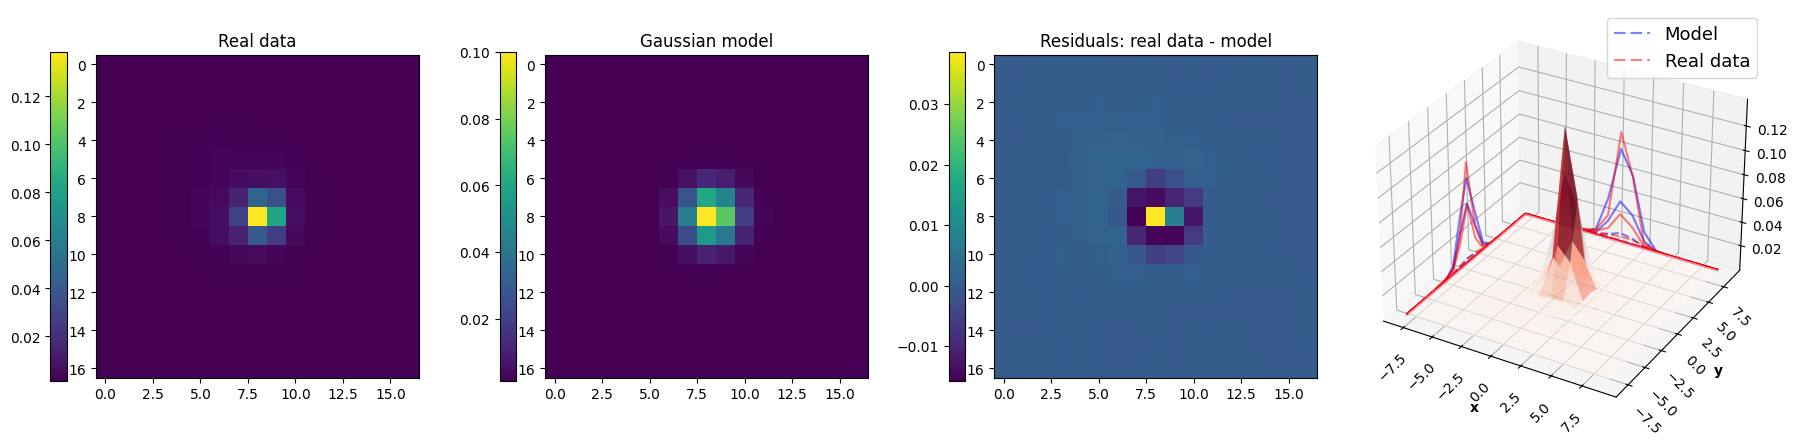

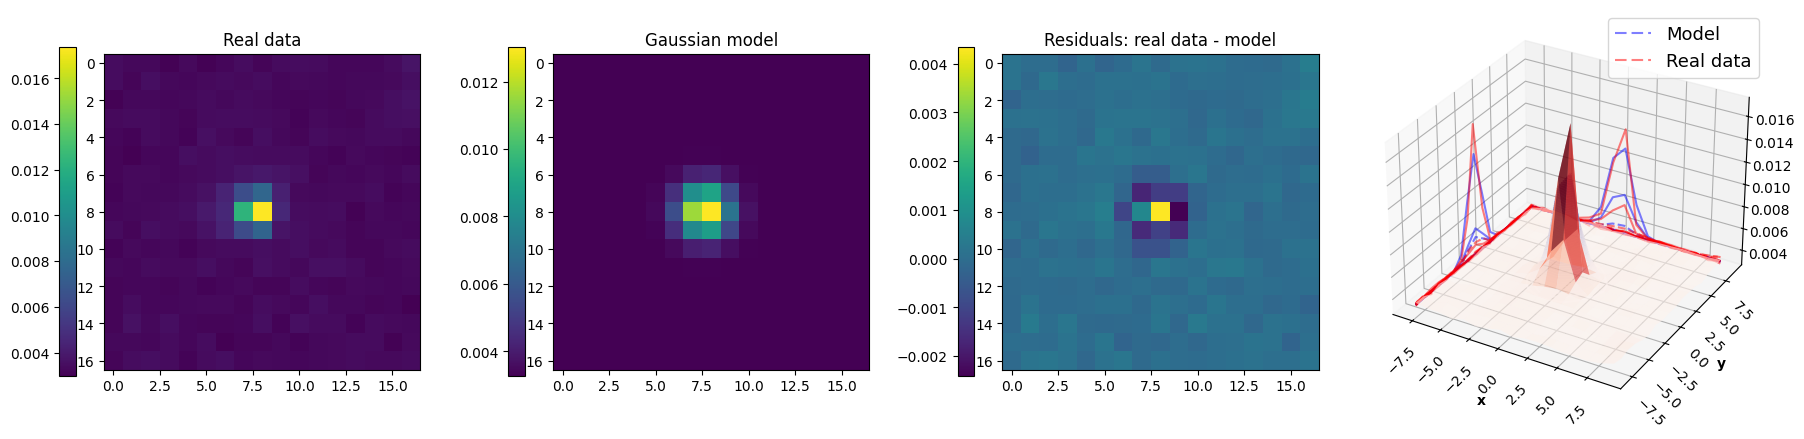

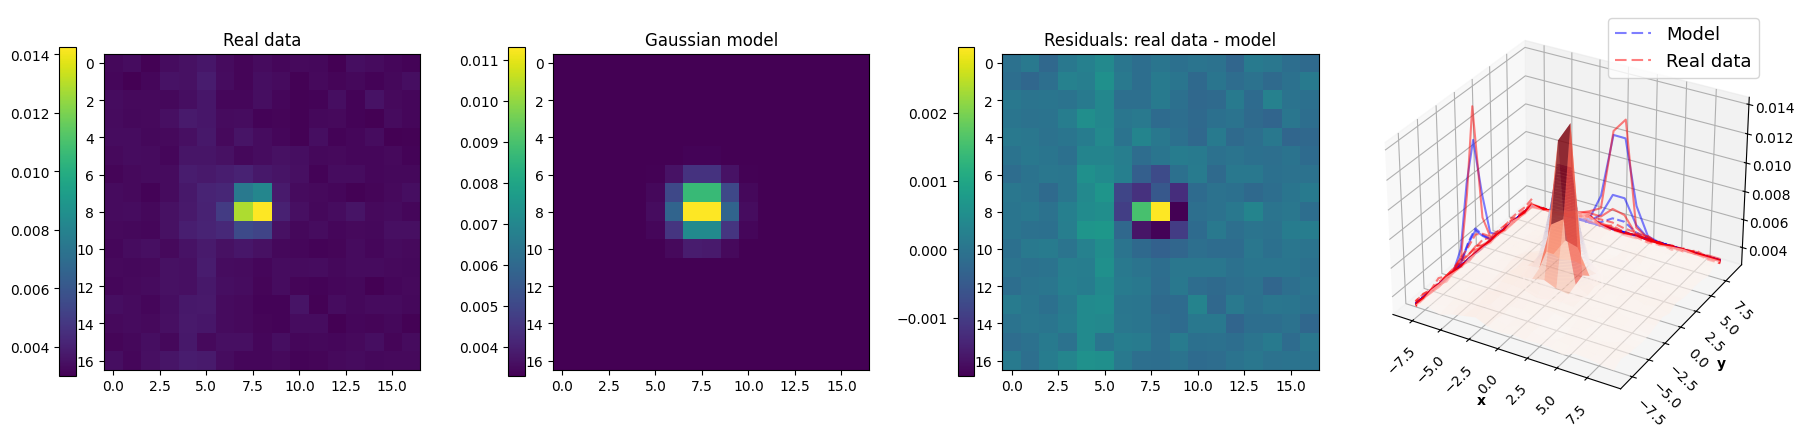

CPU times: user 11.5 s, sys: 403 ms, total: 11.9 s
Wall time: 12 s


In [8]:
%%time

total_images = 10 # number of data items selected in the dataframe
end = qimg_catalog_isolated_mag_bord.head(total_images)
size = 17
params = (0, 0, 1, 0.5, 1.0, 0) # initial parameters for the model
results = end.apply(custom_function, axis=1)   